In [3]:
import pandas as pd
import os
import glob
import numpy as np
import time
from datafeed.factor_engine import FactorEngine
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


h:\workspace\kaki\kkexpr\src\data


In [8]:
data_dir: str = "../data/indexes"
symbols: list = ['000300.SH', '000905.SH']
dfs = []
for symbol in symbols:
    file_path = os.path.join(data_dir, f"{symbol}.csv")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Data file not found for {symbol} at {file_path}")
    
    # Read CSV and add symbol column
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    dfs.append(df)

# Stack all dataframes
data = pd.concat(dfs, axis=0)

# Set multi-index
data = data.set_index(['date', 'symbol']).sort_index()

# Drop any duplicate columns (like 'symbol' that might be in the CSV)
data = data[['open', 'high', 'close', 'low', 'volume']]

In [9]:
data

open      high     close       low         volume
date       symbol                                                          
2005-01-04 000300.SH  994.7690  994.7690  982.7940  980.6580   7412868.9400
           000905.SH  996.6820  996.6820  986.9270  984.7950   2323762.0300
2005-01-05 000300.SH  981.5770  997.3230  992.5640  979.8770   7119108.9800
           000905.SH  986.5700 1008.8550 1003.6330  985.6770   3486101.1300
2005-01-06 000300.SH  993.3310  993.7880  983.1740  980.3300   6288029.0500
...                        ...       ...       ...       ...            ...
2024-06-14 000905.SH 5180.2887 5235.8781 5213.0927 5163.3840 133998620.0000
2024-06-17 000300.SH 3521.4365 3540.7932 3536.1986 3520.7381 137433438.0000
           000905.SH 5189.2840 5223.5894 5207.1280 5184.5987 107970664.0000
2024-06-18 000300.SH 3533.4875 3551.7085 3545.5902 3532.7845 123671838.0000
           000905.SH 5207.9777 5243.5867 5230.8913 5204.9707  94090903.0000

[9450 rows x 5 columns]

In [10]:
enable_rust = True
# Initialize factor engine
engine = FactorEngine(use_rust=enable_rust)

# Define factors to compute
factors = {
    'momentum': {'lookback': 20},  # Short-term momentum
    'mean_reversion': {'lookback': 10},  # Short-term mean reversion
    'alpha42': {}  # Volume-price correlation factor
}

# Compute each factor
results = pd.DataFrame(index=data.index)
impl = "Rust" if enable_rust else "Python"
print(f"\nComputing factors using {impl} implementation...")

for factor_name, kwargs in factors.items():
    print(f"\nComputing {factor_name}...")
    if not enable_rust:
        expr = engine.factor_expressions[factor_name](**kwargs)
        print(f"Expression: {expr}")
    
    start_time = time.time()
    results[factor_name] = engine.execute_factor(data, factor_name, **kwargs)
    elapsed = time.time() - start_time
    print(f"Time taken: {elapsed:.4f} seconds")



Computing factors using Rust implementation...

Computing momentum...
Time taken: 0.0010 seconds

Computing mean_reversion...
Time taken: 0.0000 seconds

Computing alpha42...
Time taken: 0.0030 seconds


In [11]:
results

momentum  mean_reversion  alpha42
date       symbol                                      
2005-01-04 000300.SH       NaN             NaN      NaN
           000905.SH       NaN             NaN      NaN
2005-01-05 000300.SH       NaN             NaN      NaN
           000905.SH       NaN             NaN      NaN
2005-01-06 000300.SH       NaN             NaN      NaN
...                        ...             ...      ...
2024-06-14 000905.SH   -0.0455         -0.9995   0.1125
2024-06-17 000300.SH   -0.0309          1.0023   0.2354
           000905.SH   -0.0483         -0.9929   0.1804
2024-06-18 000300.SH   -0.0304          0.9917   0.2187
           000905.SH   -0.0207         -1.0180   0.3581

[9450 rows x 3 columns]

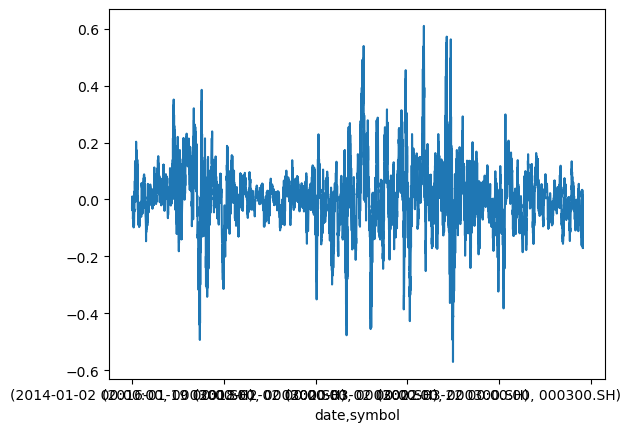

In [13]:
# Plot 000300.SH
results.loc['2014-01-01':'2024-01-31', 'momentum'].plot()



In [14]:
# Use DIY factor
# Define a new DIY factor expression
def diy_factor_expr() -> str:
    """Get DIY factor expression."""
    return "ts_mean(close, 10) / ts_std(close, 10)"

# Add the new factor to the factor engine
engine.factor_expressions['diy_factor'] = diy_factor_expr

# Compute the new DIY factor
print("\nComputing diy_factor...")
if not enable_rust:
    expr = engine.factor_expressions['diy_factor']()
    print(f"Expression: {expr}")

start_time = time.time()
results['diy_factor'] = engine.execute_factor(data, 'diy_factor')
elapsed = time.time() - start_time
print(f"Time taken: {elapsed:.4f} seconds")




Computing diy_factor...
Time taken: 0.0020 seconds


In [15]:
results['diy_factor']

date        symbol   
2005-01-04  000300.SH      NaN
            000905.SH      NaN
2005-01-05  000300.SH      NaN
            000905.SH      NaN
2005-01-06  000300.SH      NaN
                         ...  
2024-06-14  000905.SH   4.9821
2024-06-17  000300.SH   4.9556
            000905.SH   4.9565
2024-06-18  000300.SH   4.9584
            000905.SH   4.9519
Name: diy_factor, Length: 9450, dtype: float64